In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [5]:
# --------------------------
# 1. LOAD STOCK DATA (AAPL)
# --------------------------
df = yf.download("AAPL", period="5y")
prices = df["Close"].values.reshape(-1,1)

# Z-score scaling (better for time series)
scaler = StandardScaler()
prices_norm = scaler.fit_transform(prices)

[*********************100%***********************]  1 of 1 completed


In [15]:
# --------------------------
# 2. CREATE 10-DAY AHEAD SEQUENCES
# --------------------------
def create_sequences(data, seq_len=60, horizon=10):
    X, Y = [], []
    for i in range(len(data) - seq_len - horizon):
        X.append(data[i : i+seq_len])
        Y.append(data[i+seq_len+horizon])
    return np.array(X), np.array(Y)

seq_len = 60
horizon = 10   # <<< Predict 10 days ahead
X, Y = create_sequences(prices_norm, seq_len, horizon)



In [16]:
# Train/val split
split = int(len(X)*0.8)
X_train, X_val = X[:split], X[split:]
Y_train, Y_val = Y[:split], Y[split:]

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val   = torch.tensor(X_val,   dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_val   = torch.tensor(Y_val,   dtype=torch.float32)

In [7]:
# --------------------------
# 3. MODELS
# --------------------------
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(1, 64, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])  


class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, 64, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


In [8]:
# --------------------------
# 4. TRAIN FUNCTION
# --------------------------
def train(model, name):
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    for epoch in range(80):
        model.train()
        pred = model(X_train)
        loss = loss_fn(pred, Y_train)

        opt.zero_grad()
        loss.backward()
        opt.step()

        model.eval()
        with torch.no_grad():
            vpred = model(X_val)
            vloss = loss_fn(vpred, Y_val)

        if epoch % 10 == 0:
            print(f"{name}: Epoch {epoch} | Train={loss.item():.4f} | Val={vloss.item():.4f}")
    
    return vpred



In [9]:
# --------------------------
# 5. RUN BOTH MODELS
# --------------------------
print("\n=== RNN 10-DAY FORECAST ===")
rnn_pred = train(RNN(), "RNN")

print("\n=== LSTM 10-DAY FORECAST ===")
lstm_pred = train(LSTM(), "LSTM")




=== RNN 10-DAY FORECAST ===
RNN: Epoch 0 | Train=0.7073 | Val=2.4220
RNN: Epoch 10 | Train=0.3057 | Val=1.3143
RNN: Epoch 20 | Train=0.0967 | Val=0.2523
RNN: Epoch 30 | Train=0.0594 | Val=0.2461
RNN: Epoch 40 | Train=0.0511 | Val=0.1876
RNN: Epoch 50 | Train=0.0510 | Val=0.1699
RNN: Epoch 60 | Train=0.0504 | Val=0.1759
RNN: Epoch 70 | Train=0.0498 | Val=0.1614

=== LSTM 10-DAY FORECAST ===
LSTM: Epoch 0 | Train=0.6678 | Val=1.8296
LSTM: Epoch 10 | Train=0.4888 | Val=1.7845
LSTM: Epoch 20 | Train=0.3078 | Val=1.6331
LSTM: Epoch 30 | Train=0.1753 | Val=1.0179
LSTM: Epoch 40 | Train=0.0776 | Val=0.2910
LSTM: Epoch 50 | Train=0.0579 | Val=0.2488
LSTM: Epoch 60 | Train=0.0574 | Val=0.1914
LSTM: Epoch 70 | Train=0.0552 | Val=0.1840


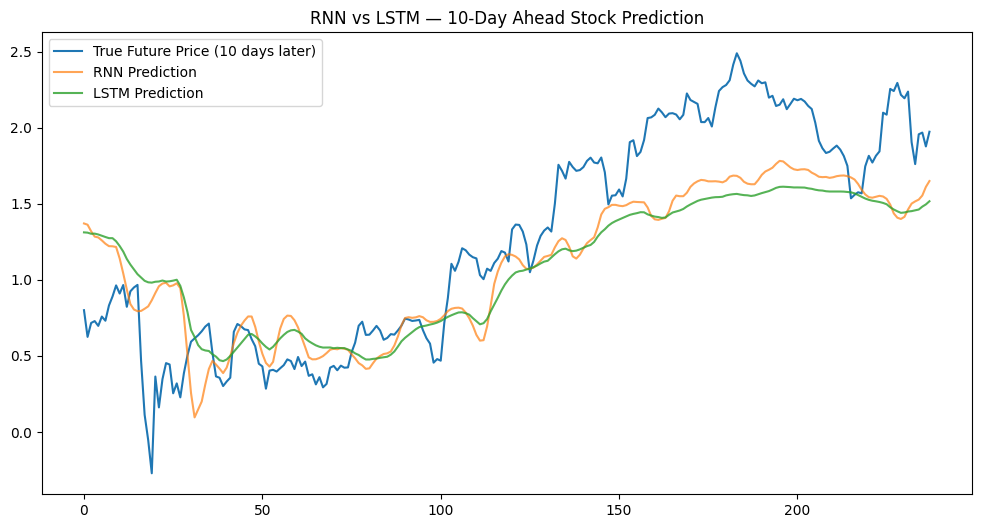

In [10]:
# --------------------------
# 6. PLOT RESULTS
# --------------------------
plt.figure(figsize=(12,6))
plt.plot(Y_val.numpy(), label="True Future Price (10 days later)")
plt.plot(rnn_pred.detach().numpy(), label="RNN Prediction", alpha=0.7)
plt.plot(lstm_pred.detach().numpy(), label="LSTM Prediction", alpha=0.8)
plt.legend()
plt.title("RNN vs LSTM — 10-Day Ahead Stock Prediction")
plt.show()
